In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcs import stat_graph
%matplotlib inline

In [2]:
### FUNCTIONS ###
zscore = lambda x: (x-x.mean())/x.std()

In [3]:
# Load data files
cc_df = pd.read_csv('../raw_files/incontact_calls.csv',parse_dates=['ic_date'])
promo = pd.read_excel('../raw_files/nat_promo.xlsx',parse_dates=['ic_date']).set_index('ic_date')

In [4]:
cc_df.head()

,ic_date,ic_month,ic_year,ic_isoweek,ic_isodow,ic_isoyear,ic_call_grouping,ic_calls,ic_first_contacts,ic_second_contacts
0,2016-06-08,6,2016,23,3,2016,NaN,5,0,0
1,2016-06-09,6,2016,23,4,2016,NaN,8,0,0
2,2016-07-01,7,2016,26,5,2016,NaN,1,0,0
3,2016-07-12,7,2016,28,2,2016,NaN,1,0,0
4,2016-07-13,7,2016,28,3,2016,NaN,13,0,0


<h2>My First goal is to figure out what the ideal dependent variable</h2>

Steps I'll Take
<ul>
    <LI>Look at correlations of different phone number groups</LI>
    <LI>Look at magnitue of different phone number groups</LI>
</ul>

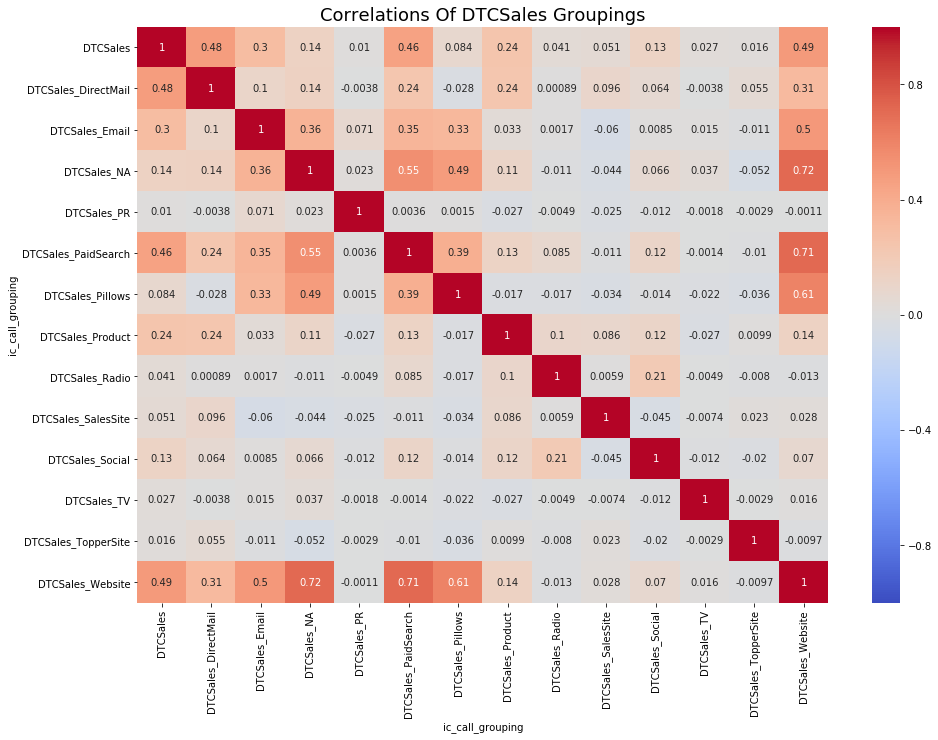

In [5]:
## Is there a correlation between DTC groupings & what is the magnitude
# pivot by call grouping, daily
cc_grouping_piv = cc_df[cc_df['ic_date']>='2017'].pivot_table('ic_calls','ic_date','ic_call_grouping', aggfunc=np.sum,fill_value=0,)

fig = plt.figure(figsize=(12,8))
ax = fig.add_axes([0,0,1,1])
sns.heatmap(cc_grouping_piv.corr(),annot=True,ax=ax,cmap='coolwarm',vmin=-1,vmax=1)
plt.title('Correlations Of DTCSales Groupings',size=18);


<h3>It looks like there is no 1 for 1 correlation between any call center groups but DTCSales_Website is
approaching a strong correlation with DTCSales_na & DTCSales_PaidSearch. I may want to combine these two and use as my dependant variable</h3>

<h3> Next, I'll look at the magnitude (size) of each call center grouping </h3>
<BR>

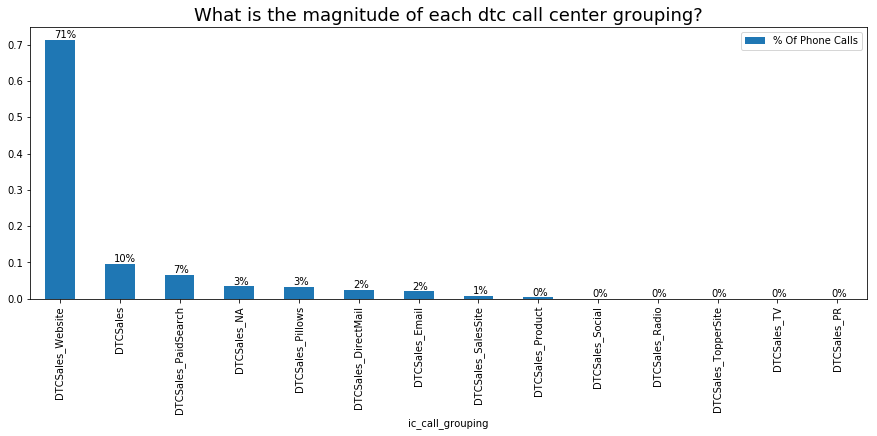

In [6]:
## What is the magnitude
magnitude_data = (cc_grouping_piv.sum()/cc_grouping_piv.sum().sum()).to_frame().sort_values(0,ascending=False)

magnitude_data.plot(kind='bar',figsize=(15,5))

    
plt.legend(labels=['% Of Phone Calls'])
plt.title('What is the magnitude of each dtc call center grouping?',size=18)

for i,col in enumerate(magnitude_data.index):
    plt.annotate(xy=(i-.1,magnitude_data.loc[col] + .005),s='{:0.0f}%'.format(magnitude_data.loc[col][0]*100))

Text(0.5,1,'Magnitude % of Each Call Center Grouping By Year')

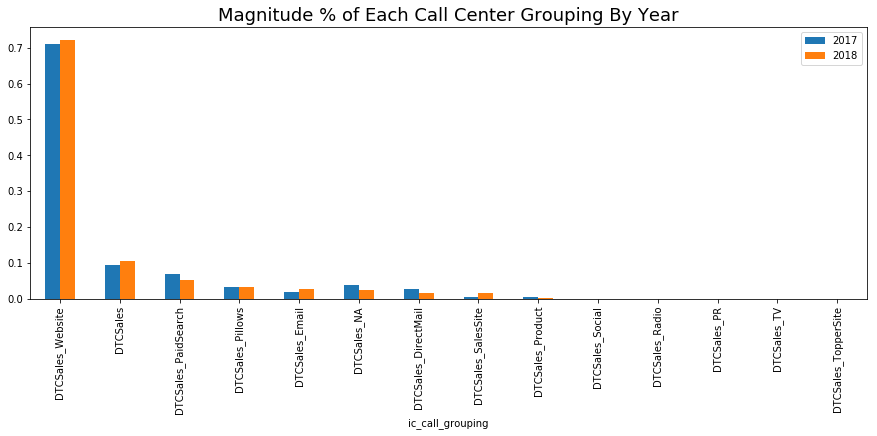

In [7]:
## Has the magnitude changed?
## What is the magnitude
mag1 = (cc_grouping_piv['2017'].sum()/cc_grouping_piv['2017'].sum().sum()).to_frame()
mag1.columns = ['2017']
mag2 = (cc_grouping_piv['2018'].sum()/cc_grouping_piv['2018'].sum().sum()).to_frame()
mag2.columns = ['2018']
mag = mag1.join(mag2).sort_values('2018',ascending=False)
mag.plot(kind='bar',figsize=(15,5))
plt.title('Magnitude % of Each Call Center Grouping By Year',size=18)

Text(0.5,1,'Percent Of Phone Calls by Grouping Over Time')

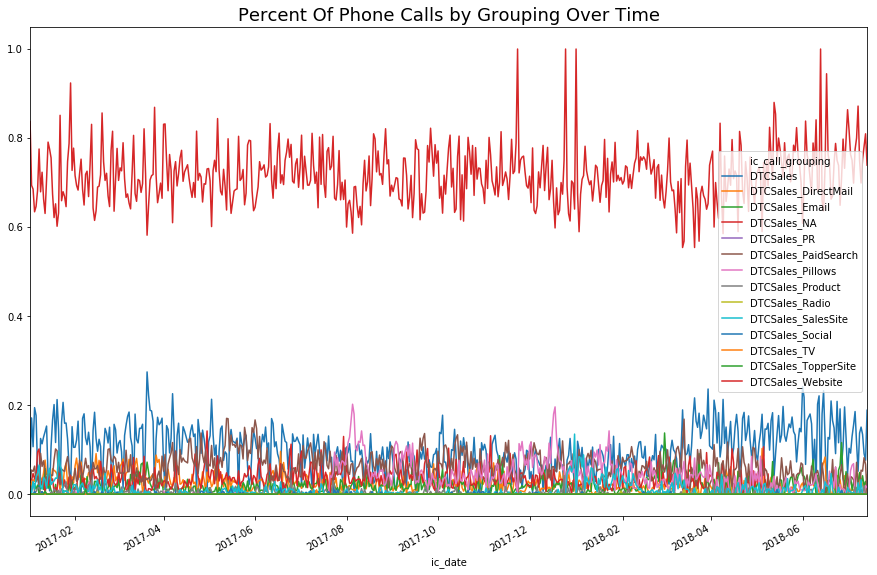

In [8]:
## How has the magnitude changed over time?
cc_grouping_piv.transform(lambda x: x/cc_grouping_piv.sum(axis=1)).plot(figsize=(15,10))
plt.title('Percent Of Phone Calls by Grouping Over Time',size=18)

<h3>It looks like the three groupings of DTCSales_Website, DTCSales_PaidSearch, and DTCSales are over 75% of the DTC call center calls. Over time, the % of calls hasn't changed very much.</h3>

<h3>It looks like DTCSales increased it's % of a calls starting in march 2018, when we started to see a larger fall off in calls</h3>

<h3>Next we want to see what the actual decrease looks like on those three groupings. We'll look at YOY decreases, the long term trend, and a statisitcal hypothesis test</h3>

In [9]:
cc_grouping = ['DTCSales_Website','DTCSales_DirectMail']

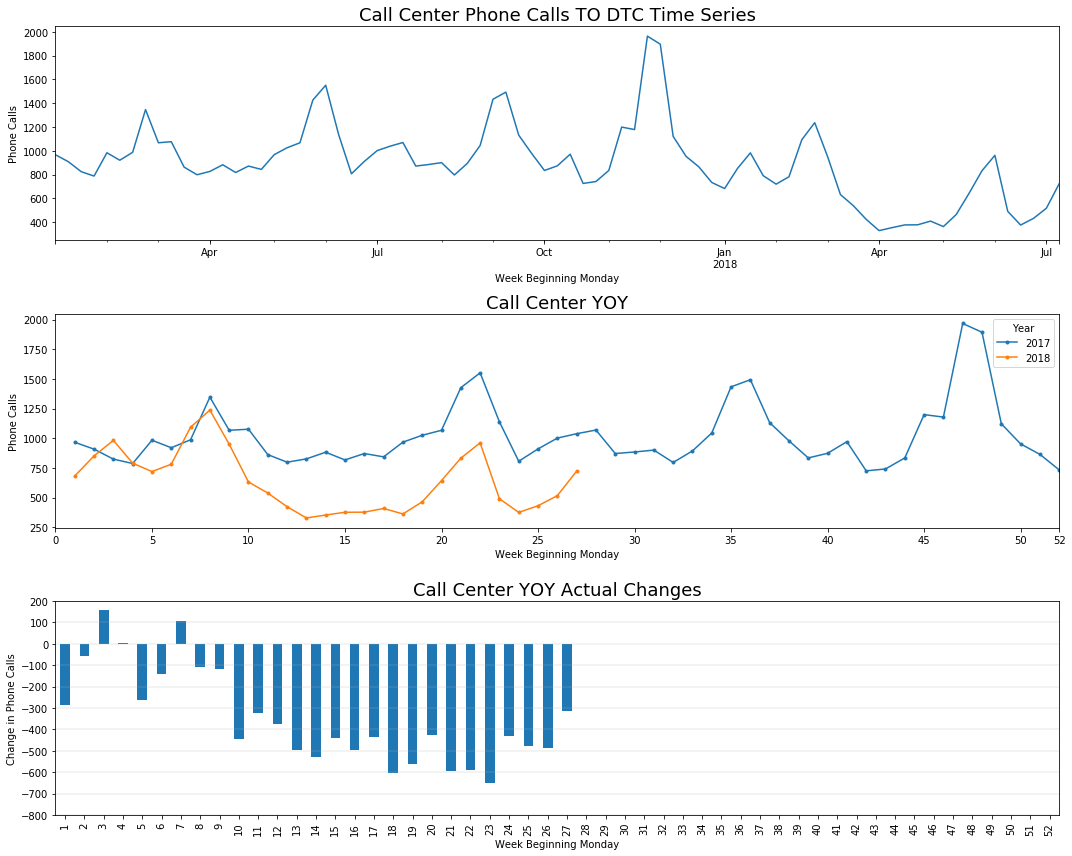

In [10]:
## PLOT Timeseries
fig,(ax,ax1,ax2) = plt.subplots(3,1,figsize=(15,12))
cc_ts = cc_grouping_piv.resample('w-sun').sum()[cc_grouping].sum(axis=1).iloc[:-1]
cc_ts.plot(ax=ax)
ax.set_title('Call Center Phone Calls TO DTC Time Series',size=18);
ax.set_ylabel('Phone Calls');
ax.set_xlabel('Week Beginning Monday');

## Plot YOY
cc_yoy = cc_df[cc_df['ic_date']>='2017'].pivot_table('ic_calls',['ic_isoyear','ic_isoweek'],'ic_call_grouping', aggfunc=np.sum,fill_value=0,)
cc_yoy = cc_yoy[cc_grouping].sum(axis=1).iloc[:-1].reset_index().pivot_table(0,'ic_isoweek','ic_isoyear',aggfunc=np.sum)
cc_yoy.plot(ax=ax1,marker='.')
ax1.set_xticks([0,5,10,15,20,25,30,35,40,45,50,52])
ax1.set_title('Call Center YOY',size=18)
ax1.set_ylabel('Phone Calls')
ax1.set_xlabel('Week Beginning Monday')
ax1.legend(title='Year')

(cc_yoy[2018]-cc_yoy[2017]).plot(kind='bar',ax=ax2)
ax2.set_title('Call Center YOY Actual Changes',size=18)
ax2.set_ylabel('Change in Phone Calls')
ax2.set_xlabel('Week Beginning Monday')
ax2.set_ylim(bottom=ax2.get_ylim()[0],top=200)
ax2.set_yticks([-800,-700,-600,-500,-400,-300,-200,-100,0,100,200])
ax2.grid(axis='y',linewidth=0.3)
plt.tight_layout()


In [11]:
max_neg,min_neg = (cc_yoy[2018]-cc_yoy[2017])[:9].min(),(cc_yoy[2018]-cc_yoy[2017])[9:].max()
print('Weeks 1-9 Largest Negative Change: {:.0f}\nWeeks 10+ Smallest Negative Change: {:0.0f}'.format(max_neg,min_neg))

Weeks 1-9 Largest Negative Change: -284
Weeks 10+ Smallest Negative Change: -315


<h3>It seems that our YOY decline began on week 10 or week beginning march 5th, 2018. It's also the week we ended our president's day promotion in 2018.
<BR><BR></BR></BR>
Although we were down in the first 9 weeks combined, there were weeks where we were up. Next, we'll combine some statisical tests to see if there was a true change throuh the first 9 weeks. I don't believe a test is needed from week 10 and on.</h3>

<H3>Hypothesis: There is no statistical difference between call center volume throughout the first 9 weeks of the year in 2018 vs 2017 at a 95% confidence interval<BR></BR>

<BR></BR>Statistic: Difference of Means (2018 average week volume less 2017 average week volume)</H3>

P-Value: 0.1880


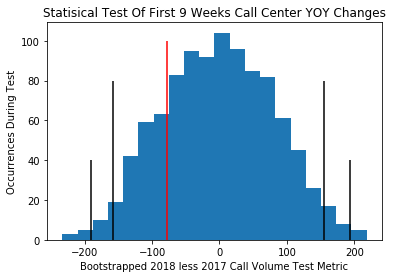

In [12]:
cc_2018 = cc_yoy.iloc[:9,1]
cc_2017 = cc_yoy.iloc[:9,0]
obs_metric = cc_2018.mean() - cc_2017.mean()

cc_combined = np.concatenate([cc_2018,cc_2017])

n = 1000
bs_metrics = np.empty(n)
np.random.seed(1)
for i in range(n):
    bs_permutation = np.random.permutation(cc_combined)
    bs_2018 = bs_permutation[len(cc_2018):]
    bs_2017 = bs_permutation[:len(cc_2018)]
    bs_metrics[i] = bs_2018.mean() - bs_2017.mean()

hst = plt.hist(bs_metrics,bins=20)
_ = plt.vlines(obs_metric,0,100,color='red')
for i in np.percentile(bs_metrics,[2.5,97.5]):
    _ = plt.vlines(i,0,80)
    
for i in np.percentile(bs_metrics,[.5,99.5]):
    _ = plt.vlines(i,0,40)    
_ = plt.title('Statisical Test Of First 9 Weeks Call Center YOY Changes')
_ = plt.ylabel('Occurrences During Test')
_ = plt.xlabel('Bootstrapped 2018 less 2017 Call Volume Test Metric')
print('P-Value: {:.4f}'.format(np.sum(obs_metric>bs_metrics)/len(bs_metrics)))

In [13]:
np.percentile(bs_metrics,[.5,99.5]),obs_metric

(array([-190.78666667,  193.47444444]), -78.11111111111109)

<h3>Although we observed a decline of 100 calls per week on average for weeks 1-9, we accept the hypothesis that there wasn't a difference between call center volume in 2018 over 2017 during weeks 1-9.
<BR></BR><BR></BR>
What was the average decline post week 9?
</h3>

In [14]:
cc_2018 = cc_yoy.iloc[10:27,1]
cc_2017 = cc_yoy.iloc[10:27,0]
obs_metric_2 = (cc_2018.mean() - cc_2017.mean())
print('Weeks 10+ Avg CC Change: {:.1f}\nWeeks 10+ Change to Weeks 1-9 Change: {:.1f}'.format(obs_metric_2, obs_metric_2/obs_metric))

Weeks 10+ Avg CC Change: -484.0
Weeks 10+ Change to Weeks 1-9 Change: 6.2


<h3>There was an average decline of 484 calls per week after 9. This decrease is 6.2 times that of what we saw in weeks 1-9</h3>

<h3>Now that we know the change started on week 10, we can look for any changes to our website, our advertising program, competitive marketing, how users visit our website, and different actions taken on our website to see if this aligns with the sudden fall off in phone calls</h3>

<h2>Website Changes On 3/8/2018 (the week call center volume began a steep decline)</h2>

•	Launch Pre-Approvals which includes moving to a four-step checkout process(NOTE: The back end will be launched, but the feature will not be turned on until further testing is complete)

•	Launching new Retail Locator Experience at www.tempurpedic.com/find-a-retailer2/ (NOTE: We will not be driving consumer traffic to this URL, but please feel free to use it and provide feedback)

•	Update Wells Fargo name to Wells Fargo Bank, N.A. 

•	Revert vanity phone number back to standard 888-811-5053

•	A/B Test #1: Testing if Firm vs Soft is a better conversion thank Firm vs Medium vs Soft in the Best Seller module on the Homepage 

•	A/B Test #2 (continuing): Test a more visually enticing upsell of TEMPUR-Ergo Plus vs the existing upsell carousel of Premier/Plus/Flat foundation when adding a mattress to cart from any mattress product page to see if adjustable base attach rate increases 
<h2>The Change in phone numbers is extremely interesting  on this week as it coincides with the fall in call center phone calls </h2>

•	A follow up from Amy McSharry on 7/12/2018 stated that we changed from the standard phone number of 888-811-5053 to 844-6-TEMPUR. We moved to the vanity phone number on 11/20/17 (week 47).


<H2>Changes to the Interactive Voice Response (IVR) on 3/13/2018</H2>

Goal: make consumer experience more positive (Get them to where they want to go faster)

•	 "For sales press 1" to "To place a new order for a TempurPedic Product please press one." on date 3/13/2018

<h3>I'll look at the yoy call changes going back to 7/1/2017 and see if there we're trend changes after moving to the vanity phone number or after updating the IVR</h3>


2018 Wk 13 - 18 YOY Avg Change: -56.7%


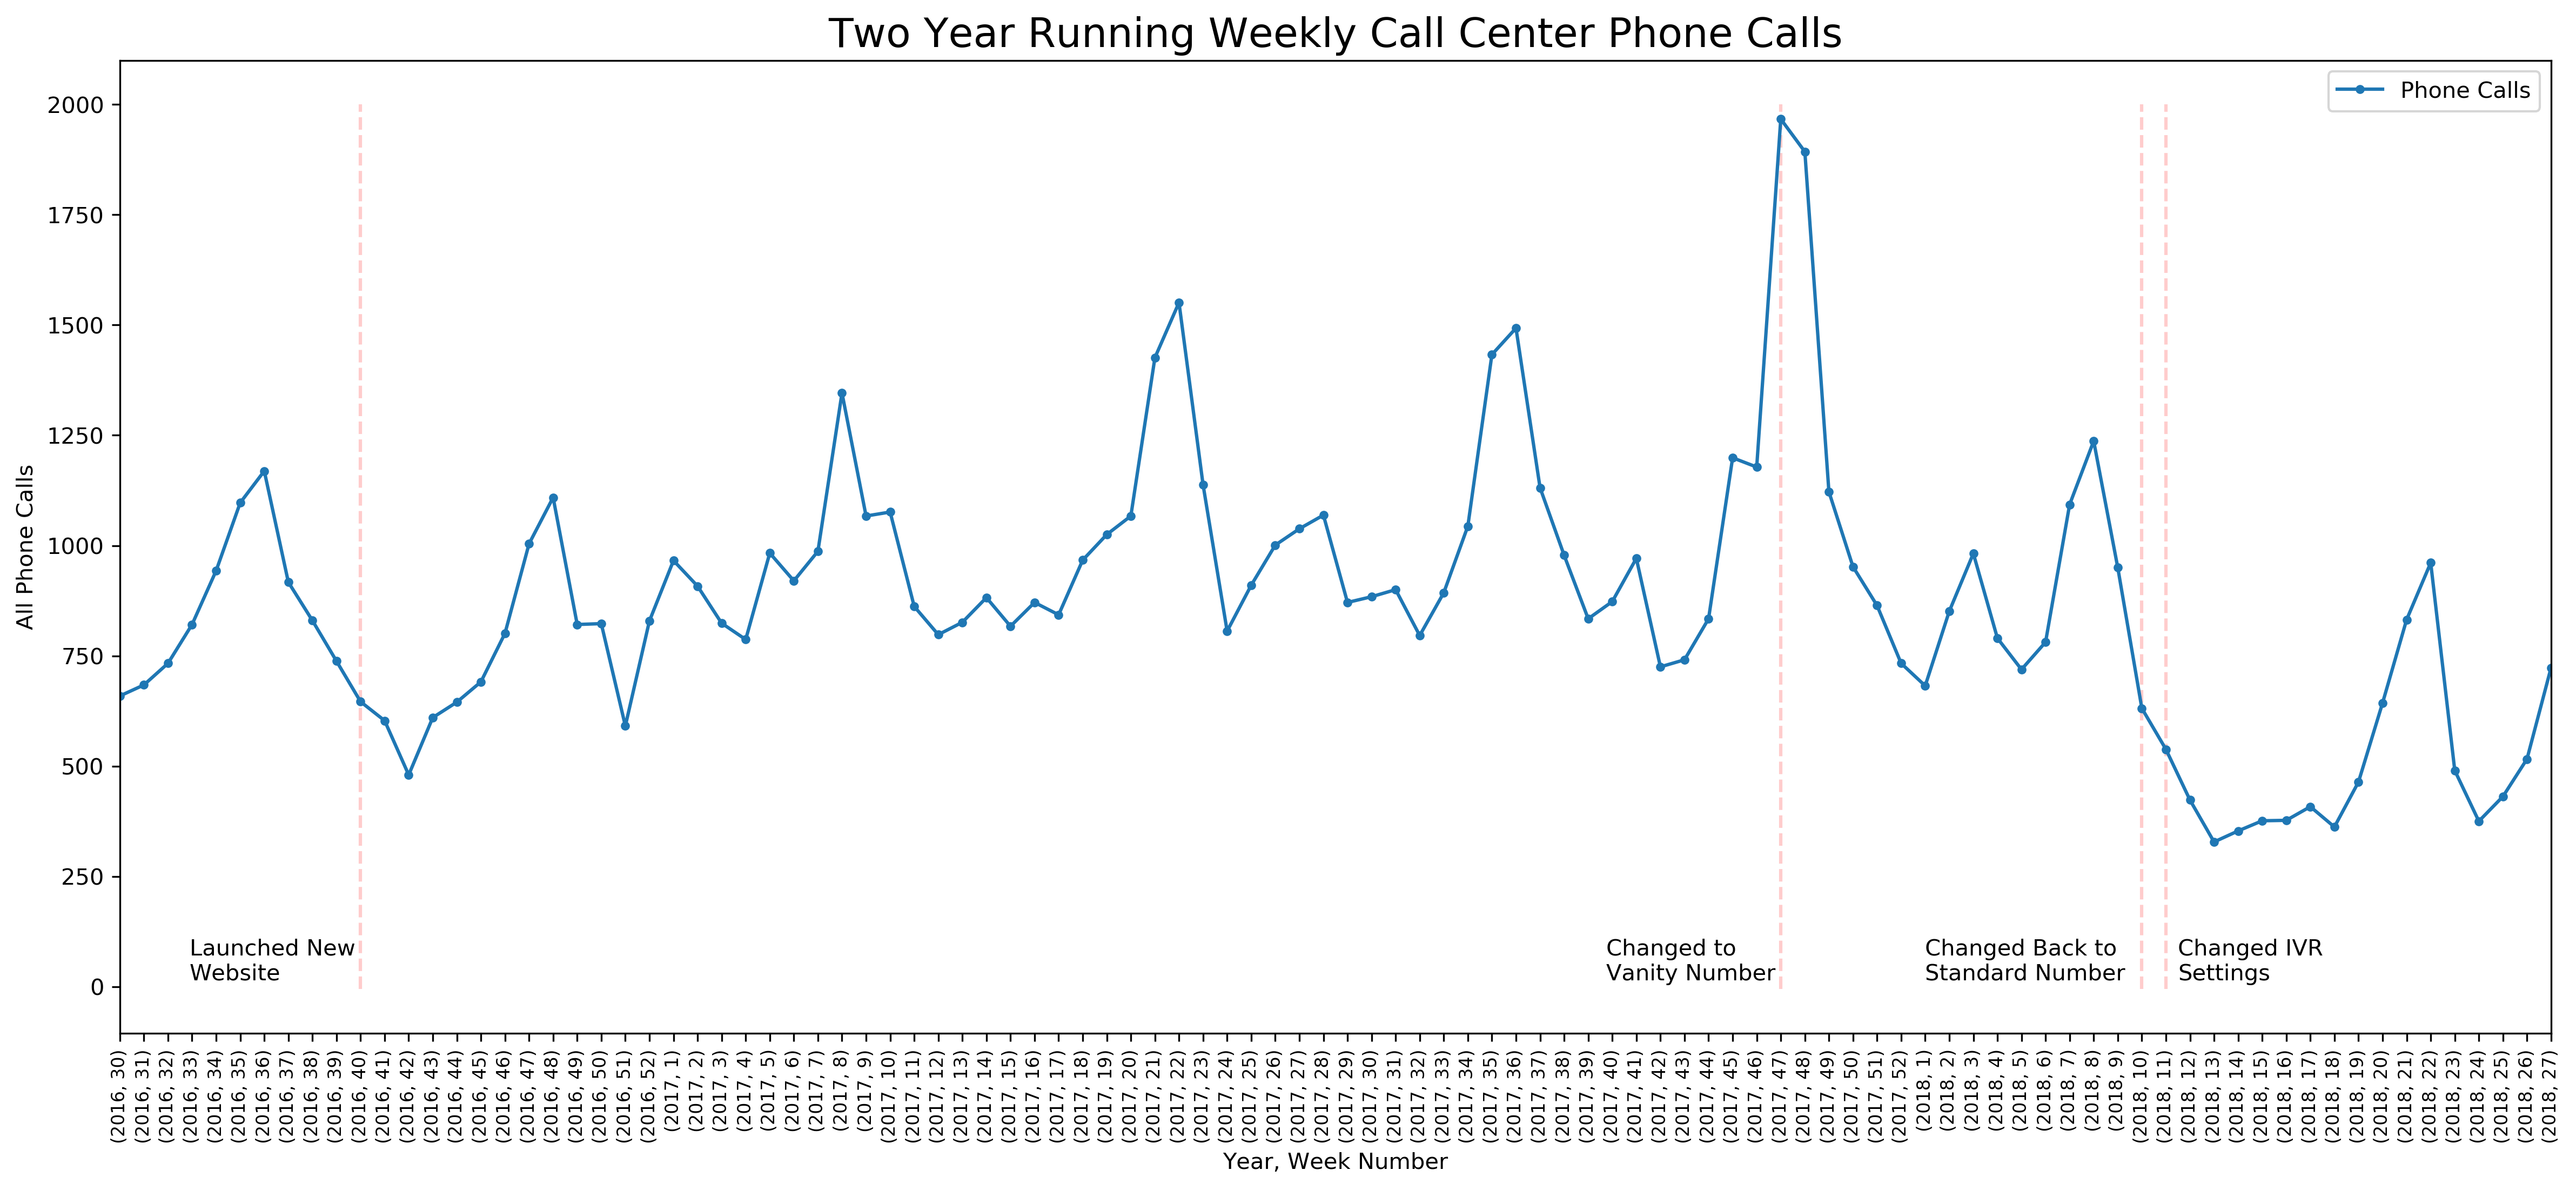

In [15]:
cc_wkly = cc_df.pivot_table('ic_calls',['ic_isoyear','ic_isoweek'],'ic_call_grouping', aggfunc=np.sum,fill_value=0,)[cc_grouping].sum(axis=1).iloc[1:-1]
cc_wkly = cc_wkly.reset_index()
#cc_trailing_wkly = pd.concat([pd.concat([cc_wkly[2016],cc_wkly[2017]]),pd.concat([cc_wkly[2017],cc_wkly[2018]]),],axis=1)
#cc_trailing_wkly.columns = ['2016-2017','2017-2018']
#x = cc_trailing_wkly.reset_index()[['ic_isoweek']].values
#y1 = cc_trailing_wkly.reset_index()[['2016-2017']].values
#y2 = cc_trailing_wkly.reset_index()[['2017-2018']].values
#np.stack([x,])
df = cc_wkly.set_index(['ic_isoyear','ic_isoweek'])
df.columns=['Phone Calls']
fig = plt.figure(figsize=(15,6),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax = df.plot(ax=ax,marker='.')
ax.set_xticks(range(len(df.index)));
ax.set_xticklabels(df.index, rotation=90,size=8);
ax.set_title('Two Year Running Weekly Call Center Phone Calls',size=18);
ax.set_ylabel('All Phone Calls')
ax.set_xlabel('Year, Week Number')

plt.vlines(x=69,ymin=-5,ymax=2000,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(61.75,15),xytext=(61.75,15),s='Changed to\nVanity Number');

plt.vlines(x=84,ymin=-5,ymax=2000,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(75,15),xytext=(75,15),s='Changed Back to\nStandard Number');

plt.vlines(x=85,ymin=-5,ymax=2000,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(85.5,15),xytext=(85.5,15),s='Changed IVR\nSettings');

plt.vlines(x=10,ymin=-5,ymax=2000,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(2.9,15),xytext=(2.9,15),s='Launched New\nWebsite');

print('2018 Wk 13 - 18 YOY Avg Change: {:.1f}%'.format((((df.loc[(2018,13):(2018,18),].mean()/df.loc[(2017,13):(2017,17),].mean())-1).values*100)[0]))

<H2>PLOT FIRST TIME CALLERS AND THEN 2ND CONTACT CALLERS</H2>

2018 Wk 13 - 18 YOY Avg Change: -62.0%


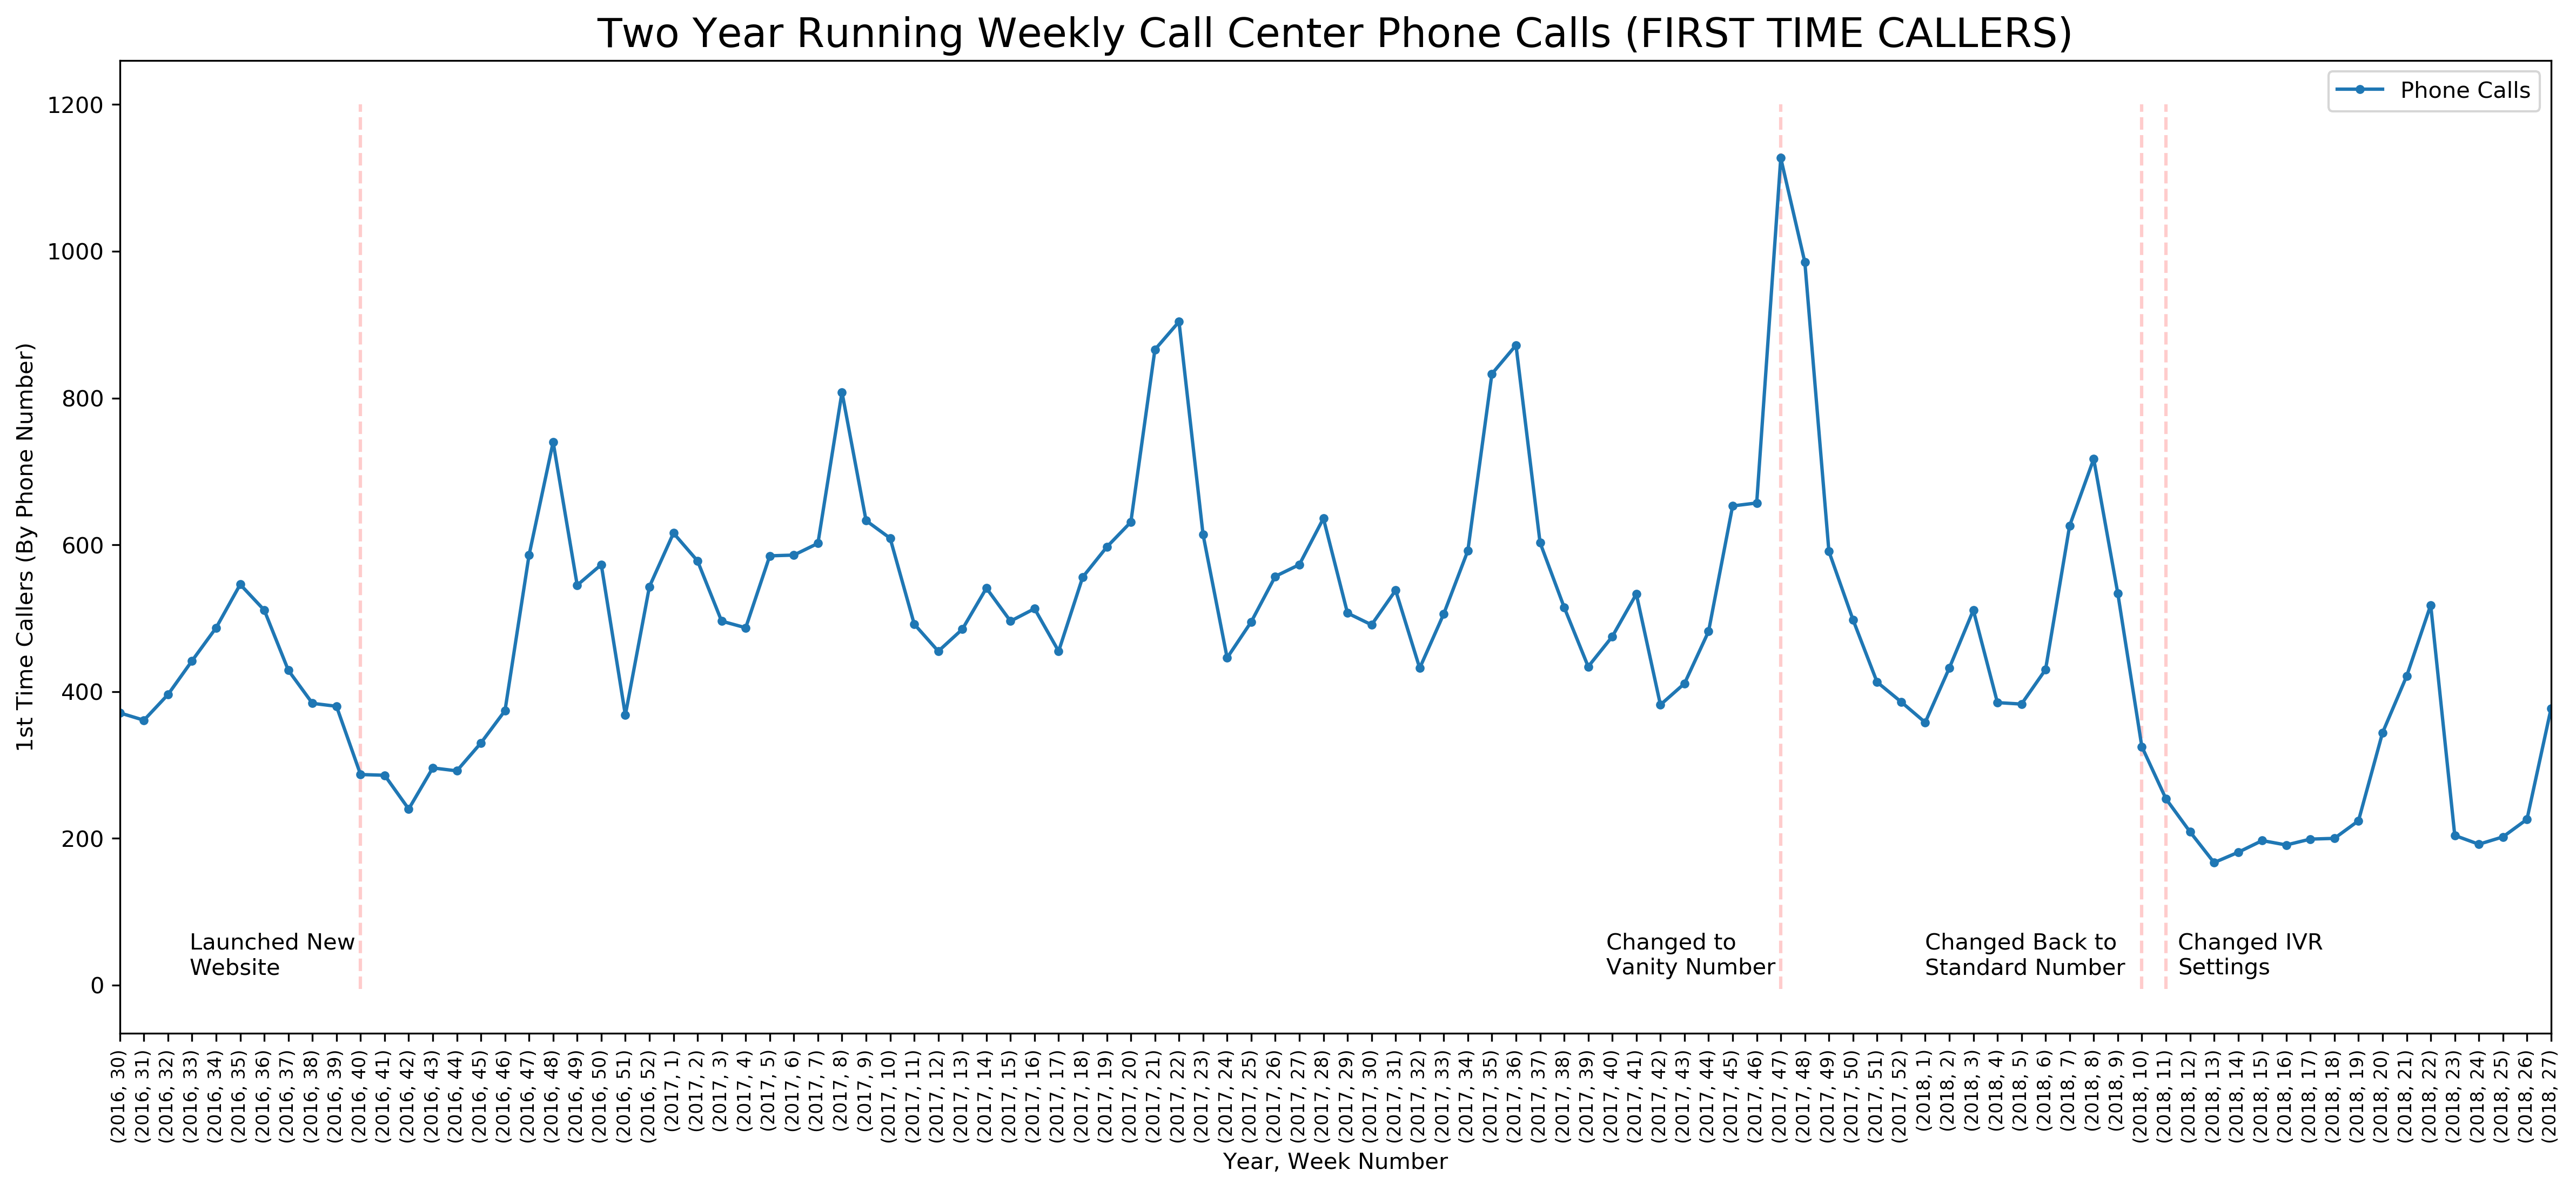

In [16]:
cc_wkly = cc_df.pivot_table('ic_first_contacts',['ic_isoyear','ic_isoweek'],'ic_call_grouping', aggfunc=np.sum,fill_value=0,)[cc_grouping].sum(axis=1).iloc[1:-1]
cc_wkly = cc_wkly.reset_index()
#cc_trailing_wkly = pd.concat([pd.concat([cc_wkly[2016],cc_wkly[2017]]),pd.concat([cc_wkly[2017],cc_wkly[2018]]),],axis=1)
#cc_trailing_wkly.columns = ['2016-2017','2017-2018']
#x = cc_trailing_wkly.reset_index()[['ic_isoweek']].values
#y1 = cc_trailing_wkly.reset_index()[['2016-2017']].values
#y2 = cc_trailing_wkly.reset_index()[['2017-2018']].values
#np.stack([x,])
df = cc_wkly.set_index(['ic_isoyear','ic_isoweek'])
df.columns=['Phone Calls']
fig = plt.figure(figsize=(15,6),dpi=300)
ax = fig.add_axes([0,0,1,1])
ax = df.plot(ax=ax,marker='.')
ax.set_xticks(range(len(df.index)));
ax.set_xticklabels(df.index, rotation=90,size=8);
ax.set_title('Two Year Running Weekly Call Center Phone Calls (FIRST TIME CALLERS)',size=18);
ax.set_ylabel('1st Time Callers (By Phone Number)')
ax.set_xlabel('Year, Week Number')

plt.vlines(x=69,ymin=-5,ymax=1200,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(61.75,15),xytext=(61.75,15),s='Changed to\nVanity Number');

plt.vlines(x=84,ymin=-5,ymax=1200,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(75,15),xytext=(75,15),s='Changed Back to\nStandard Number');

plt.vlines(x=85,ymin=-5,ymax=1200,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(85.5,15),xytext=(85.5,15),s='Changed IVR\nSettings');

plt.vlines(x=10,ymin=-5,ymax=1200,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(2.9,15),xytext=(2.9,15),s='Launched New\nWebsite');

print('2018 Wk 13 - 18 YOY Avg Change: {:.1f}%'.format((((df.loc[(2018,13):(2018,18),].mean()/df.loc[(2017,13):(2017,17),].mean())-1).values*100)[0]))

2018 Wk 13 - 18 YOY Avg Change: -50.9%


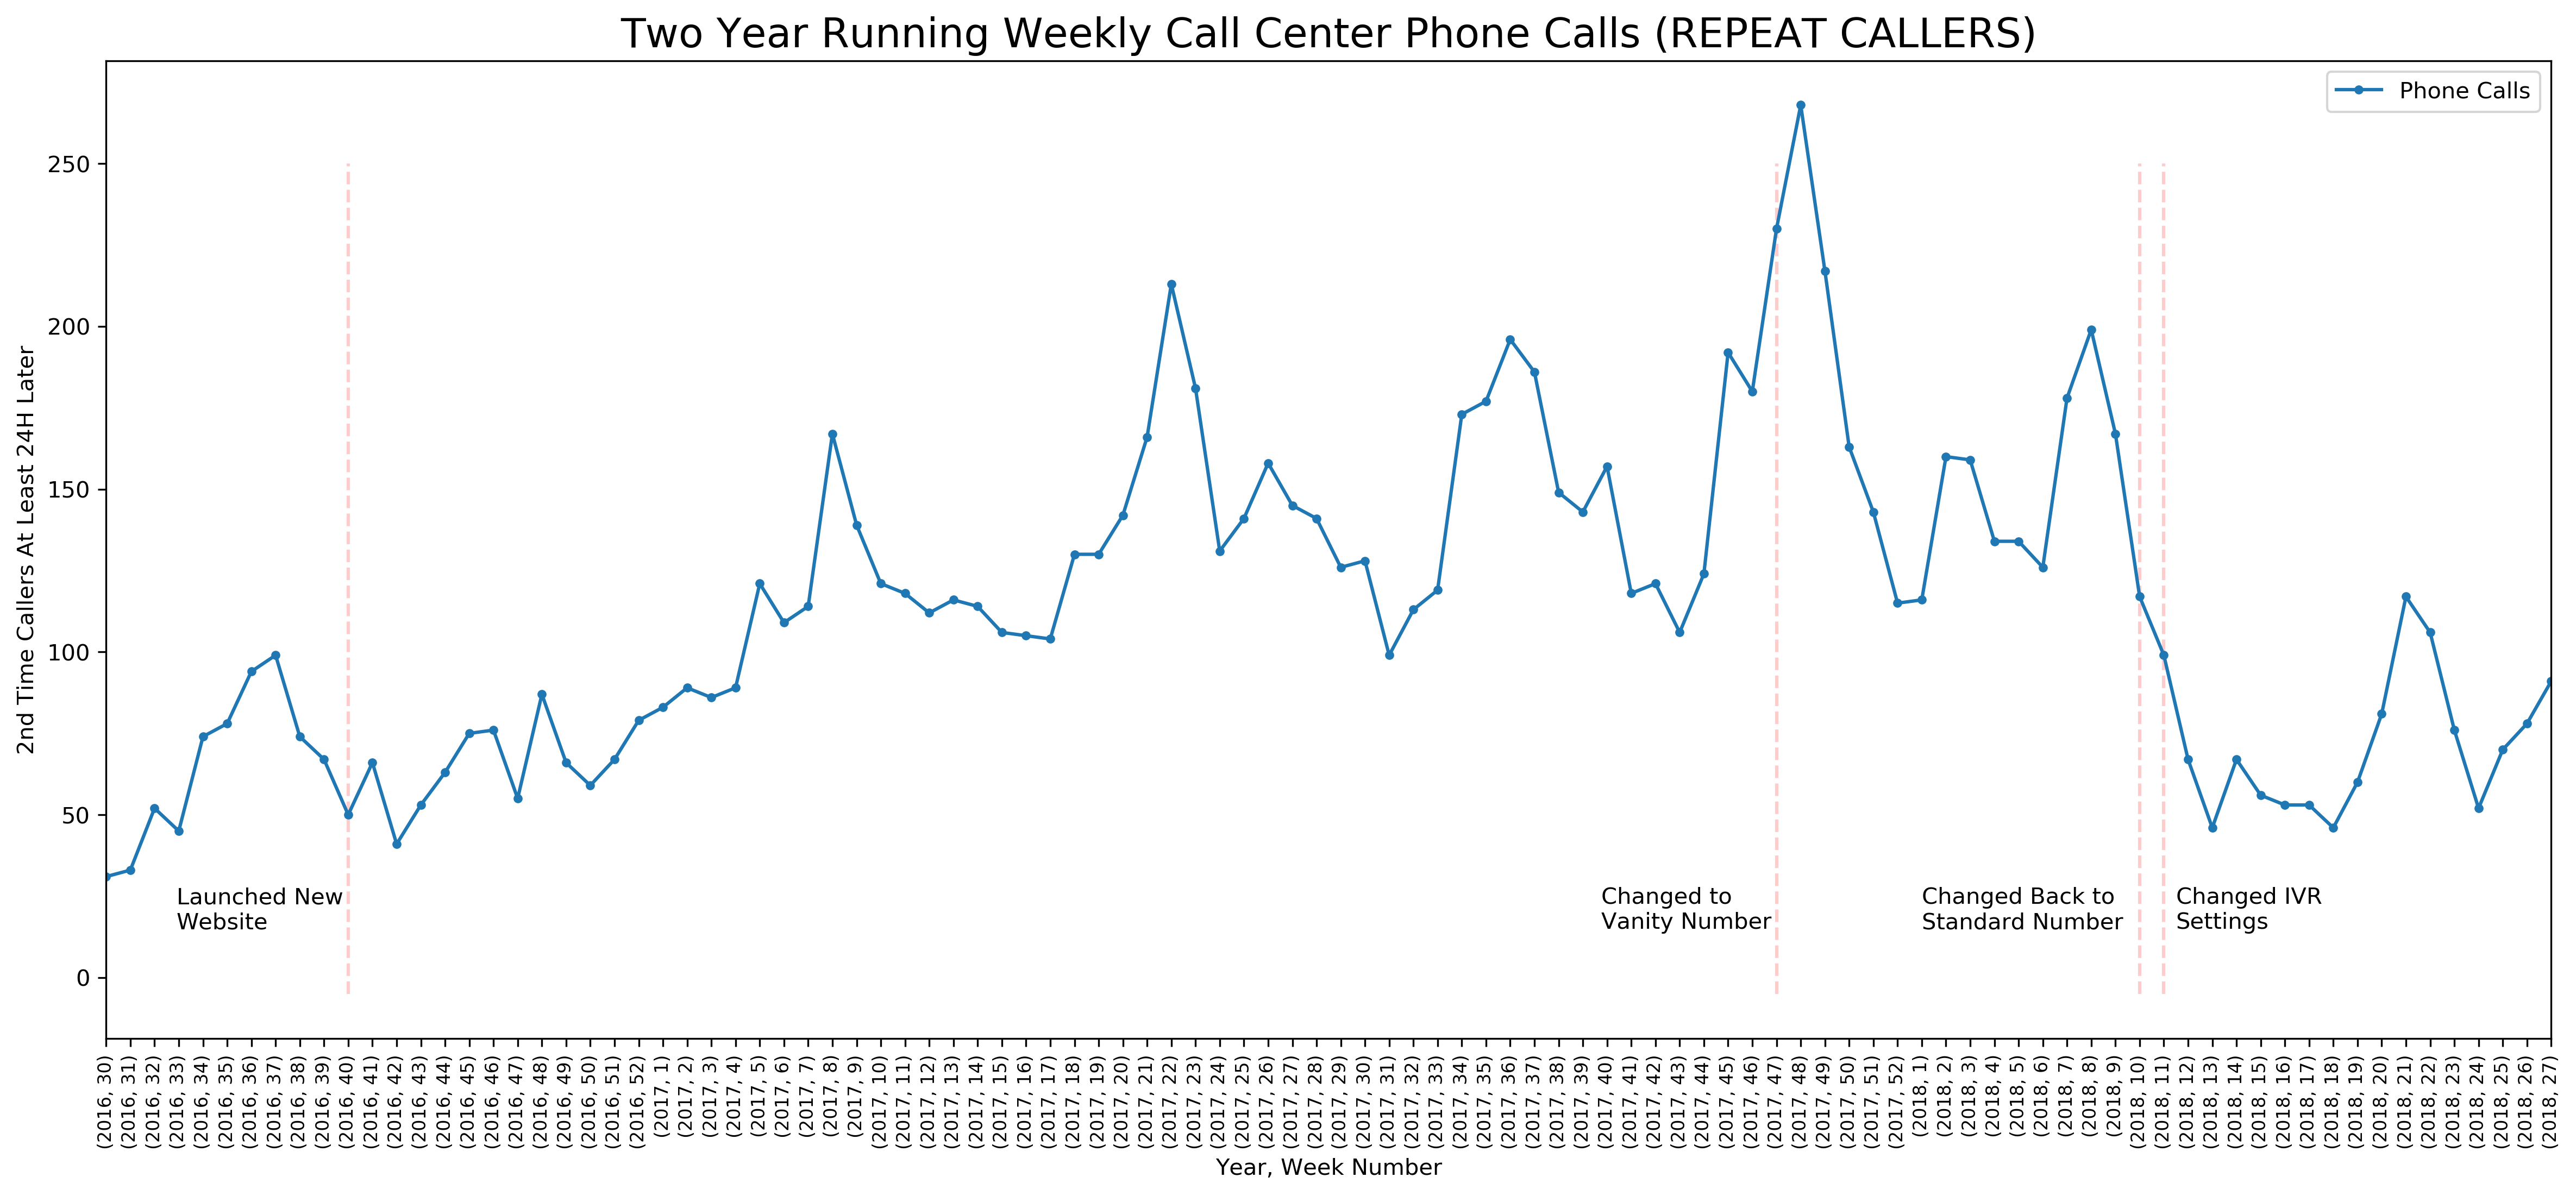

In [17]:
cc_wkly = cc_df.pivot_table('ic_second_contacts',['ic_isoyear','ic_isoweek'],'ic_call_grouping', aggfunc=np.sum,fill_value=0,)[cc_grouping].sum(axis=1).iloc[1:-1]
cc_wkly = cc_wkly.reset_index()
#cc_trailing_wkly = pd.concat([pd.concat([cc_wkly[2016],cc_wkly[2017]]),pd.concat([cc_wkly[2017],cc_wkly[2018]]),],axis=1)
#cc_trailing_wkly.columns = ['2016-2017','2017-2018']
#x = cc_trailing_wkly.reset_index()[['ic_isoweek']].values
#y1 = cc_trailing_wkly.reset_index()[['2016-2017']].values
#y2 = cc_trailing_wkly.reset_index()[['2017-2018']].values
#np.stack([x,])
df = cc_wkly.set_index(['ic_isoyear','ic_isoweek'])
df.columns=['Phone Calls']
fig = plt.figure(figsize=(15,6),dpi=300)
ax = fig.add_axes([0,0,1,1])
df.plot(ax=ax,marker='.')

ax.set_xticks(range(len(df.index)));
ax.set_xticklabels(df.index, rotation=90,size=8);

ax.set_title('Two Year Running Weekly Call Center Phone Calls (REPEAT CALLERS)',size=18);
ax.set_ylabel('2nd Time Callers At Least 24H Later')
ax.set_xlabel('Year, Week Number')

plt.vlines(x=69,ymin=-5,ymax=250,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(61.75,15),xytext=(61.75,15),s='Changed to\nVanity Number');

plt.vlines(x=84,ymin=-5,ymax=250,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(75,15),xytext=(75,15),s='Changed Back to\nStandard Number');

plt.vlines(x=85,ymin=-5,ymax=250,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(85.5,15),xytext=(85.5,15),s='Changed IVR\nSettings');

plt.vlines(x=10,ymin=-5,ymax=250,color='red',alpha=.2,linestyle='--');
plt.annotate(xy=(2.9,15),xytext=(2.9,15),s='Launched New\nWebsite');

print('2018 Wk 13 - 18 YOY Avg Change: {:.1f}%'.format((((df.loc[(2018,13):(2018,18),].mean()/df.loc[(2017,13):(2017,17),].mean())-1).values*100)[0]))

<h3>

<h2>I have two hypotheses from this section:</h2>
<h3>
<ul>
    <li>The vanity number change probably has no effects on call volume</li>
    <li>The change in IVR settings is probably a driver in the decline in call volume</li>
</ul>
</h3>
<h4>The time spent with a vanity number did not any change on call volume from before it was inplace. Because there was no significant increase, I do not believe the significant drop was caused by it (I could be wrong)</h4>

<h4>I do believe the change in IVR settings caused this drop (so far). The verbage change in week 11 may have been enough to shift consumer behavior. The verbage changed on the IVR changed from, "For sales press 1" to, "To place a new order for a TempurPedic Product please press one." A consumer under the new verbage may think they are only able to place a new order versus just talking to someone in sales in the old verbage</h4>

<h2>Next, I'll look at the effects digital advertising may have on the outcome of phone calls</h2>

In [18]:
#load google, facebook, & bing advertising
ggl_ads = pd.read_csv('../raw_files/google_ads.csv')
bing_ads = pd.read_csv('../raw_files/bing_ads.csv')
fb_ads = pd.read_csv('../raw_files/facebook_ads.csv')

In [19]:
# Transform call data into format to use with digital ads
cc_daily = cc_df.pivot_table('ic_calls',['ic_date'],'ic_call_grouping', aggfunc=np.sum,fill_value=0,)[cc_grouping].sum(axis=1).iloc[1:-1]
cc_daily.name = 'call_center'
cc_daily.index.names=['date']

# Transform google ad data into format to use with digital ads
ggl_ads_channel = ggl_ads.pivot_table('goog_impressions',['goog_date'],['goog_channel_group'],aggfunc=np.sum).iloc[1:-1]
ggl_ads_channel.index.names=['date']
ggl_ads_channel.columns = ['ggl_'+x.replace(' ','_').lower() for x in ggl_ads_channel.columns]
ggl_prod = ggl_ads.pivot_table('goog_impressions',['goog_date'],['goog_product_group'],aggfunc=np.sum).iloc[1:-1]
ggl_prod.columns = ['ggl_'+x.replace(' ','_').lower() for x in ggl_prod.columns]


# Transform bing ad data into format to use with digital ads
fb_ads_channel = fb_ads.pivot_table(['fb_impressions','fb_video_views'],['fb_date'],['fb_channel_group'],aggfunc=np.sum).iloc[1:-1].reset_index().melt(id_vars='fb_date',var_name=['metric','channel'])
fb_ads_channel['channel'] = fb_ads_channel['metric']+'_'+ fb_ads_channel['channel']
fb_ads_channel  = fb_ads_channel.pivot_table('value','fb_date','channel',aggfunc=np.sum).fillna(0)
fb_ads_channel.index.names=['date']
fb_network = fb_ads.pivot_table('fb_impressions',['fb_date'],['fb_network'],aggfunc=np.sum).iloc[1:-1]
fb_network.columns = ['fb_'+x.replace(' ','_').lower() for x in fb_network.columns]

# Transform facebook ad data into format to use with digital ads
bing_ads_channel = bing_ads.pivot_table('bing_impressions',['bing_date'],['bing_channel_group'],aggfunc=np.sum).iloc[1:-1]
bing_ads_channel.index.names=['date']
bing_ads_channel.columns = ['bing_'+x.replace(' ','_').lower() for x in bing_ads_channel.columns]
bing_ads_channel = bing_ads_channel.drop(['bing_cpa_bid_test_2','bing_cpa_bid_test_3','bing_cpa_bid_test_4','bing_cpa_test_5',],axis=1)

#Combine Digital ads with calls
dig_cc = ggl_ads_channel.join(ggl_prod).join(fb_ads_channel).join(fb_network).join(bing_ads_channel).join(promo).join(cc_daily).fillna(0)

<H2>First let's see if there are any relationships that may exist between digital advertising impressions and call center data</H2>

,call_center
ggl_competitor,-0.144917
fb_video_views_Acquisition,-0.100371
fb_video_views_Branded Search,-0.049733
fb_impressions_Branded Search,-0.031270
fb_video_views_Remarketing,-0.016631
Promo,-0.006837
ggl_non-branded_search,0.101064
bing_competitor_search,0.101950
ggl_youtube,0.104952
bing_non-branded_search,0.116446


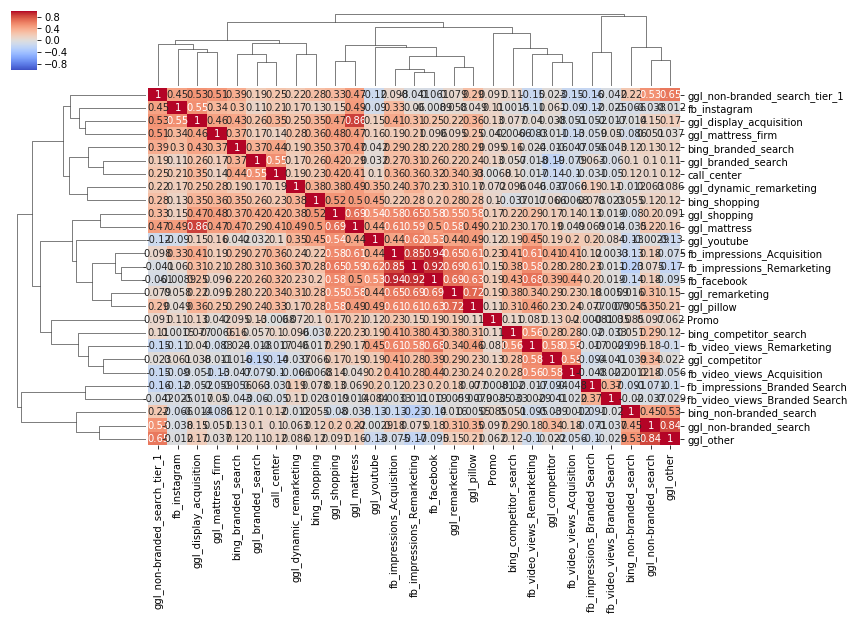

In [20]:
sns.clustermap(dig_cc.corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm',figsize=(12,8))
dig_cc.corr()['call_center'].to_frame().sort_values('call_center')

<h3>So far, correlations between impressions from our google branded search and bing branded search ad spend seem to be highest with daily DTC calls.
<BR></BR><BR></BR>
I'll look at the two variables (and a combined sum of the two) compared to the call center metrics on a daily basis to see if we can capture any trends</h3>

In [21]:
ggl_cc = stat_graph.polyfit_stats(dig_cc['ggl_branded_search'].fillna(0),dig_cc['call_center'].fillna(0),feature_units=10000)
ggl_cc.metrics(return_type='df')

,Values
Target Mean,126.654741
Correlation,0.553486
R2,0.306346
MSE,3658.481246
RMSE,60.485380
Increase Min,17.588818
Increase Median,36.478417
Increase Max,61.921365
CI_Low,23.181201
CI_High,50.591635


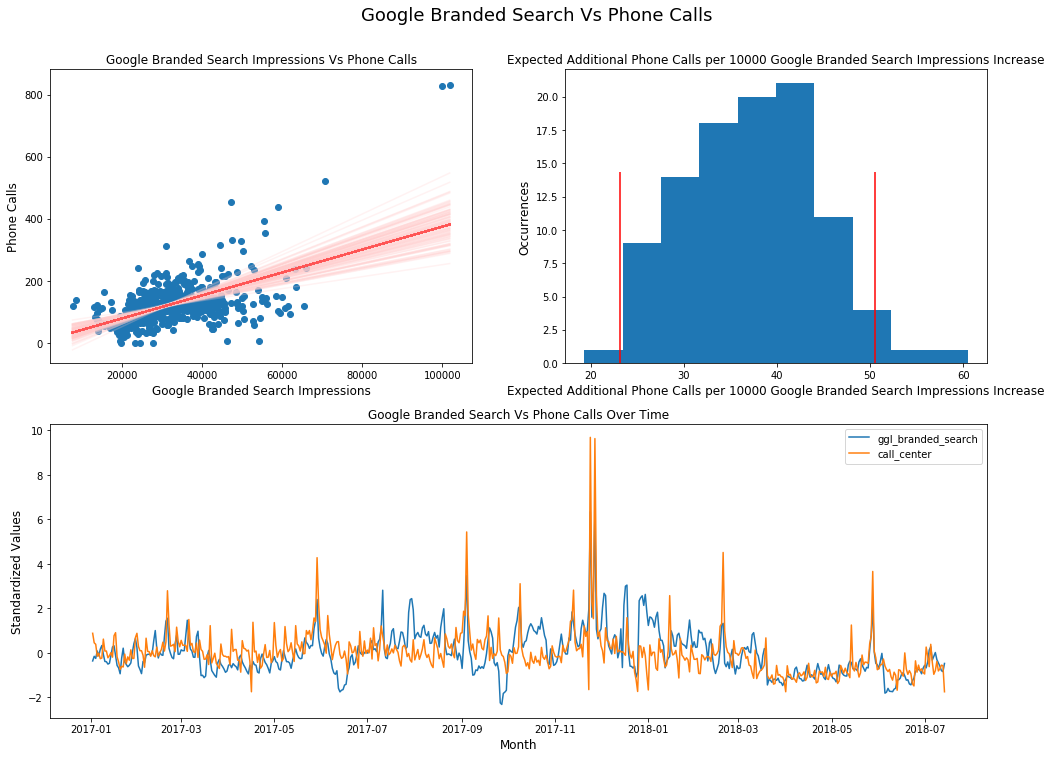

In [22]:
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

ggl_cc.fit_bs_replicates(deg=1,bs_samples=100,seed=21)

ggl_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('Google Branded Search Impressions')
ax0.set_title('Google Branded Search Impressions Vs Phone Calls')

ggl_cc.histogram(ax=ax1,bins=10)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 10000 Google Branded Search Impressions Increase')
ax1.set_title('Expected Additional Phone Calls per 10000 Google Branded Search Impressions Increase',size=12)

ggl_cc.time_series(ax=ax2,)
ax2.set_title('Google Branded Search Vs Phone Calls Over Time',size=12)

plt.suptitle('Google Branded Search Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()


<H3>It seems there is a positive trend between impressions in google branded search and call center calls on a daily basis. The trend is not 1 to 1 though as the prediction curve is +/- 47% of the daily mean. 
<BR></BR><BR></BR>
Next, I'll look at the resids to see if there is any information is not explained by google branded search
</H3>

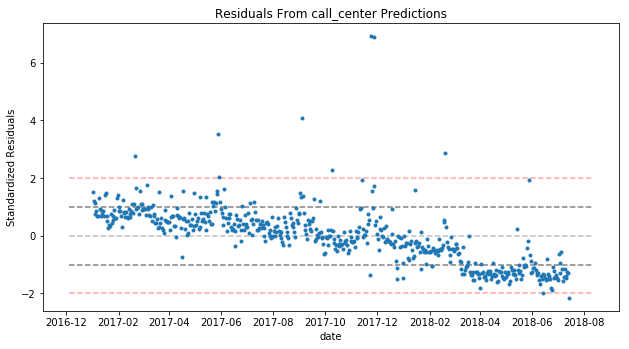

In [23]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
ggl_cc.resids(return_type='img',ax=ax)


<h3>There is a gradual downward shift from jan 2017 - march 2018 with a sudden shift in the middle of march. A couple thoughts:</h3>
<ul>
    <li>The gradual downward trend could be related to falling brand metrics. I'll bring in Brand Tracker data later on.</li>
    <li>The sudden shift in march could be related to the IVR change</li>
</ul>
<h3>Before I investigate those trends, I'll dig into bing branded search and bing + google branded search to see if bing explains any of the difference or the combined metric explain any of the difference</h3>

In [24]:
bing_cc = stat_graph.polyfit_stats(dig_cc['bing_branded_search'].fillna(0),dig_cc['call_center'].fillna(0),feature_units=10000)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
bing_cc.metrics(return_type='df')

,Values
Target Mean,126.654741
Correlation,0.444550
R2,0.197625
MSE,4231.901184
RMSE,65.053064
Increase Min,4.728028
Increase Median,8.318742
Increase Max,14.034147
CI_Low,5.794243
CI_High,11.765396


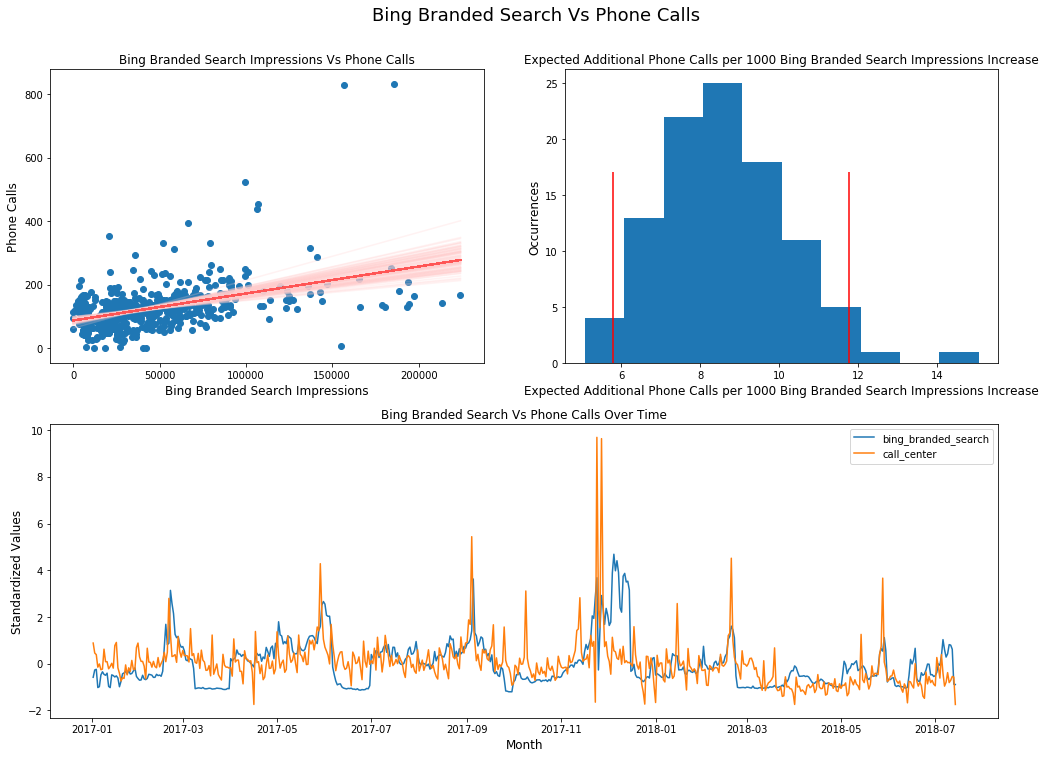

In [25]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

bing_cc.fit_bs_replicates(deg=1,bs_samples=100,seed=21)

bing_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('Bing Branded Search Impressions')
ax0.set_title('Bing Branded Search Impressions Vs Phone Calls')

bing_cc.histogram(ax=ax1,bins=10)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 1000 Bing Branded Search Impressions Increase')
ax1.set_title('Expected Additional Phone Calls per 1000 Bing Branded Search Impressions Increase',size=12)

bing_cc.time_series(ax=ax2,)
ax2.set_title('Bing Branded Search Vs Phone Calls Over Time',size=12)

plt.suptitle('Bing Branded Search Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()

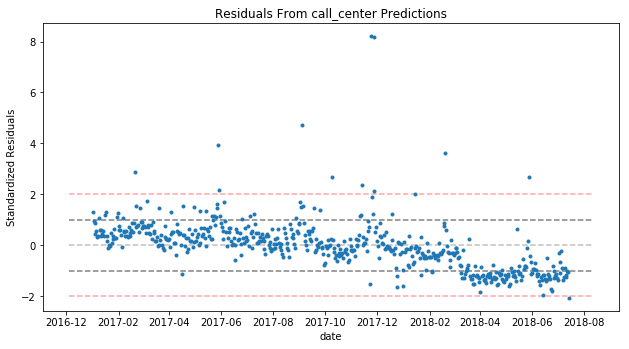

In [26]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
bing_cc.resids(return_type='img',ax=ax)

<h3>The trends with Bing Branded Search impressions are very similar to that of google branded search impressions. We see the same gradual downward trend, albeit slightly less downward. We also see the sudden shift in mid march 2018. I'd still like to dig a little deeper into Brand Tracker metrics and the IVR change</h3>

<h3>Next, I'll look at what a combined bing and google branded search metric looks like</h3>

In [27]:
bing_cc = stat_graph.polyfit_stats(dig_cc['bing_branded_search'].fillna(0)+dig_cc['ggl_branded_search'].fillna(0),dig_cc['call_center'].fillna(0),feature_units=10000)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
bing_cc.metrics(return_type='df')

,Values
Target Mean,126.654741
Correlation,0.529913
R2,0.280808
MSE,3793.178450
RMSE,61.588785
Increase Min,5.158963
Increase Median,8.798476
Increase Max,15.554283
CI_Low,6.121483
CI_High,12.361140


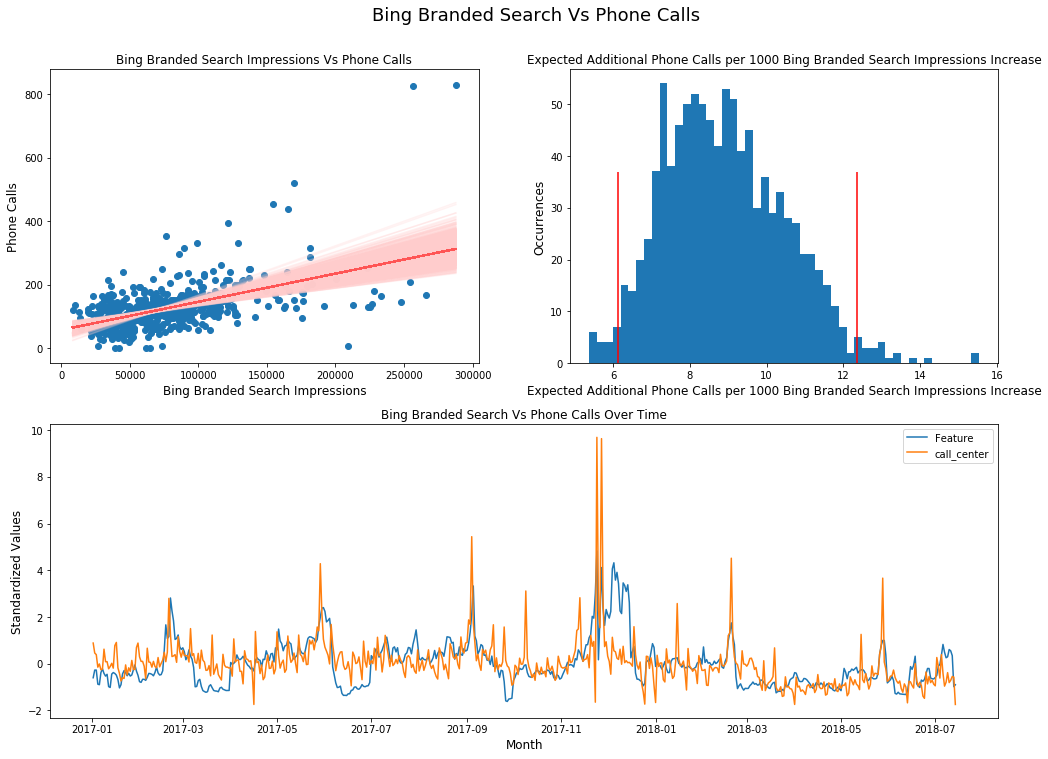

In [28]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

bing_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

bing_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('Bing Branded Search Impressions')
ax0.set_title('Bing Branded Search Impressions Vs Phone Calls')

bing_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 1000 Bing Branded Search Impressions Increase')
ax1.set_title('Expected Additional Phone Calls per 1000 Bing Branded Search Impressions Increase',size=12)

bing_cc.time_series(ax=ax2,)
ax2.set_title('Bing Branded Search Vs Phone Calls Over Time',size=12)

plt.suptitle('Bing Branded Search Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()

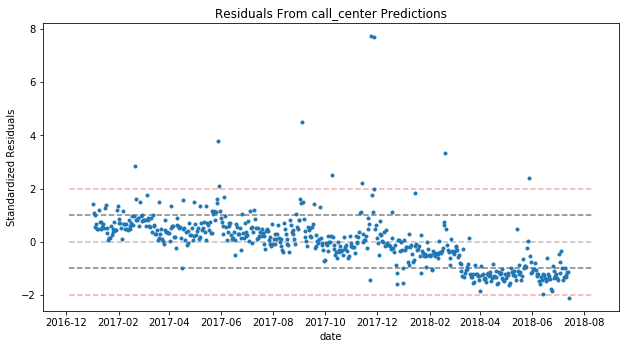

In [29]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
bing_cc.resids(return_type='img',ax=ax)

<h3>Same results as google and bing branded search separately. The combined metric could be blending heavier into google branded search as we spend more money and get more impressions there.</h3>

<h3>All of this ad data is centered around CPC arrivals. Now I'll load data directly from Google Analytics to see if there is a differnece in organic/direct visits from digital search cpc visits.</h3>

In [30]:
ga_visits = pd.read_csv('../raw_files/google_analytics.csv')

In [31]:
ga_pivot= ga_visits.pivot_table('ga_total_sessions','ga_date','ga_srcmed_group',aggfunc=np.sum).fillna(0)[1:-2]
ga_cc_daily = ga_pivot.join(cc_daily)

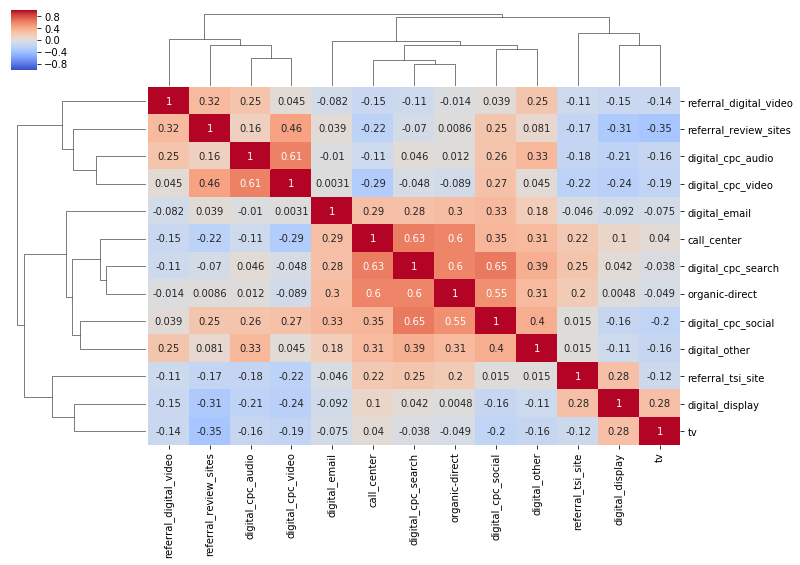

In [32]:
sns.clustermap(ga_cc_daily.corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm',figsize=(12,8))


<h3>The most interesting correlations to call center calls include organic/direct visits and digital cpc search. Let's dig into those and see what the relationship tells us</h3>

In [33]:
ga_cc = stat_graph.polyfit_stats(ga_cc_daily['organic-direct'].fillna(0),ga_cc_daily['call_center'].fillna(0),feature_units=1000)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
ga_cc.metrics(return_type='df')

,Values
Target Mean,127.122523
Correlation,0.599143
R2,0.358972
MSE,3379.716158
RMSE,58.135326
Increase Min,8.390561
Increase Median,14.611827
Increase Max,22.961664
CI_Low,10.158937
CI_High,19.436241


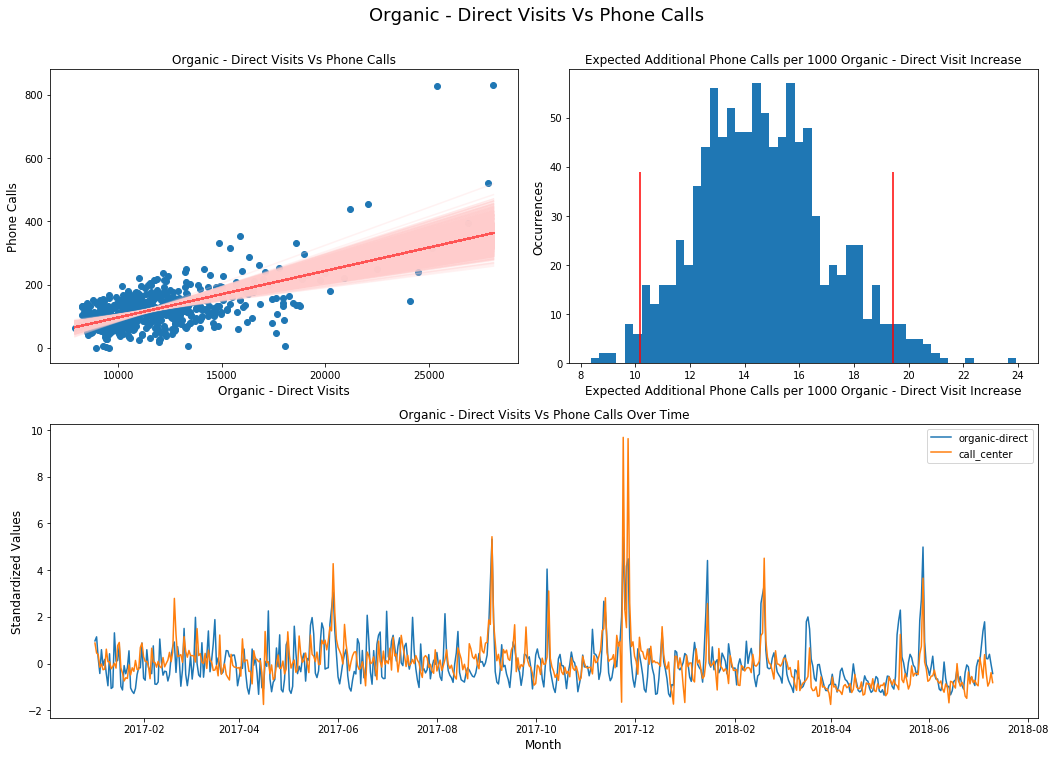

In [34]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

ga_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

ga_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('Organic - Direct Visits')
ax0.set_title('Organic - Direct Visits Vs Phone Calls')

ga_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 1000 Organic - Direct Visit Increase')
ax1.set_title('Expected Additional Phone Calls per 1000 Organic - Direct Visit Increase',size=12)

ga_cc.time_series(ax=ax2,)
ax2.set_title('Organic - Direct Visits Vs Phone Calls Over Time',size=12)

plt.suptitle('Organic - Direct Visits Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()

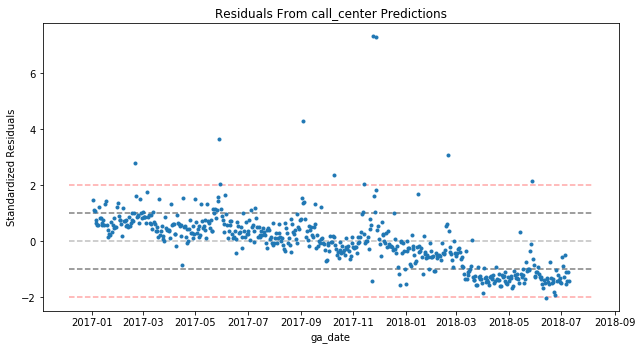

In [35]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
ga_cc.resids(return_type='img',ax=ax)

<h3>Organic Direct visits see the same trends as the trends from our digital branded search earlier.<br></br><br></br>I'll check the cpc search data but I expect much of the same as what we've seen so far.</h3>

In [ ]:
ga_cc = stat_graph.polyfit_stats(ga_cc_daily['digital_cpc_search'].fillna(0),ga_cc_daily['call_center'].fillna(0),feature_units=1000)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
print('Organic Search, Direct, and CPC Search Visits')
ga_cc.metrics(return_type='df')


Organic Search, Direct, and CPC Search Visits


,Values
Target Mean,127.122523
Correlation,0.630589
R2,0.397642
MSE,3175.835653
RMSE,56.354553
Increase Min,4.534839
Increase Median,7.790877
Increase Max,11.900369
CI_Low,5.522088
CI_High,10.165030


In [ ]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

ga_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

ga_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('Organic Search, Direct, and CPC Search Visits')
ax0.set_title('Organic Search, Direct, and CPC Search Visits Vs Phone Calls')

ga_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 1000 Organic Search, Direct, and CPC Search Visit Increase')
ax1.set_title('Expected Additional Phone Calls per 1000 Organic Search, Direct, and CPC Search Visit Increase',size=12)

ga_cc.time_series(ax=ax2,)
ax2.set_title('Organic Search, Direct, and CPC Search Visits Vs Phone Calls Over Time',size=12)

plt.suptitle('Organic Search, Direct, and CPC Search Visits Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
ga_cc.resids(return_type='img',ax=ax)

<h3>Same Trends.</h3>

<h3>Finally, let's look at brand tracker details to see if there are any brand metrics that influence call center metrics.</h3>

<H3>Brand Tracker Load</H3>

In [ ]:
bt_data = pd.read_csv('../raw_files/brand_tracker.csv',parse_dates=['bt_start_date','bt_end_date'])
bt_data = bt_data[(bt_data['bt_brands']=='Tempur-Pedic') & (bt_data['bt_n12_weighted']>0)  & (bt_data['bt_end_date']>='2017-02-17')]
bt_12_pconsid = bt_data.pivot_table('bt_n12_primary_consideration','bt_end_date','bt_segment_id',aggfunc=np.sum).fillna(0)
bt_12_primary_awareness = bt_data.pivot_table('bt_unaided_awareness_top1','bt_end_date','bt_segment_id',aggfunc=np.sum).fillna(0)
bt_12_pconsid['total'] = bt_12_pconsid.sum(axis=1)
bt_12_primary_awareness['total'] = bt_12_primary_awareness.sum(axis=1)
bt_12_intent = bt_data.pivot_table('bt_cid_weight','bt_end_date','bt_segment_id',aggfunc=np.sum).fillna(0)
bt_12_intent['total'] = bt_12_intent.sum(axis=1)

rolling = 14
bt_n12_pconsid_per = (bt_12_pconsid.rolling(rolling).sum()/bt_12_intent.rolling(rolling).sum()).iloc[rolling-1:]
bt_n12_pconsid_per.columns = ['n12pconsid_'+str(x) for x in bt_n12_pconsid_per.columns]
bt_n12_primary_awareness_per = (bt_12_primary_awareness.rolling(rolling).sum()/bt_12_intent.rolling(rolling).sum()).iloc[rolling-1:]
bt_n12_primary_awareness_per.columns = ['n12paware_'+str(x) for x in bt_n12_primary_awareness_per.columns]

In [ ]:
bt_cc_daily = bt_n12_pconsid_per.join(bt_n12_primary_awareness_per).join(cc_daily,how='outer').fillna(method='pad')['2017-03-02':'2018-07-04']

In [ ]:
sns.clustermap(bt_cc_daily.corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm',figsize=(12,8))

<h3>There doesn't seem to be a strong correlation to call center calls on a daily basis with n12 primary consideration or primary awareness. Let's look at how the data relates to call center metrics in other ways. I'll start with primary consideration then move to unaided awareness</h3>

In [ ]:
bt_cc = stat_graph.polyfit_stats(bt_cc_daily['n12pconsid_total'].fillna(0),bt_cc_daily['call_center'].fillna(0),feature_units=1)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
print('N12 Primary Consideration')
bt_cc.metrics(return_type='df')

In [ ]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

bt_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

bt_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('N12 Primary Consideration')
ax0.set_title('N12 Primary Consideration Vs Phone Calls')

bt_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per N12 Primary Consideration Increase')
ax1.set_title('Expected Additional Phone Calls per N12 Primary Consideration Increase',size=12)

bt_cc.time_series(ax=ax2,)
ax2.set_title('N12 Primary Consideration Vs Phone Calls Over Time',size=12)

plt.suptitle('N12 Primary Consideration Vs Phone Calls',y=1.05,size=18)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
bt_cc.resids(return_type='img',ax=ax)

<h3>The slow downard trend seems to be accounted for in the residuals when we compare phone calls to primary consideration. We still see a sudden drop in march 2018 though.
<br></br><br></br>
There is a lot of error in the metrics above but I believe this is due to holidays, promotions, and other time series events. I'll take out any of the days with phone calls above 200 and see how the two metrics relate</h3>

In [ ]:
bt_cc = stat_graph.polyfit_stats(bt_cc_daily[bt_cc_daily['call_center']<=200]['n12pconsid_total'].fillna(0)*100,bt_cc_daily[bt_cc_daily['call_center']<=200]['call_center'].fillna(0),feature_units=1)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
print('N12 Primary Consideration')
bt_cc.metrics(return_type='df')

In [ ]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

bt_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

bt_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('N12 Primary Consideration')
ax0.set_title('N12 Primary Consideration Vs Phone Calls')

bt_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per 100 bps N12 Primary Consideration Increase')
ax1.set_title('Expected Additional Phone Calls per 100 bps N12 Primary Consideration Increase',size=12)

bt_cc.time_series(ax=ax2,)
ax2.set_title('N12 Primary Consideration Vs Phone Calls Over Time',size=12)

plt.suptitle('N12 Primary Consideration Vs Phone Calls Less Days With 200+ Calls',y=1.05,size=18)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
bt_cc.resids(return_type='img',ax=ax)

<h3>The residuals look a lot more normal aside from the drop in march. There is a sine trend showing up with the peak in may, sept, and november. This is probably due to closeness to holidays and promotions. I'll include those in my final analysis
<br></br><br></br>
Finally, I'll look at primary awareness to see if we observe any trends. I'll filter for weeks with less than 200 calls to look at more normal call periods (not holiday)</h3>

In [ ]:
bt_cc = stat_graph.polyfit_stats(bt_cc_daily[bt_cc_daily['call_center']<=200]['n12paware_total'].fillna(0),bt_cc_daily[bt_cc_daily['call_center']<=200]['call_center'].fillna(0),feature_units=1)
#ggl_cc.confidence_intervals(ints=[.5,99.5])
print('N12 Primary Awareness')
bt_cc.metrics(return_type='df')

In [ ]:
gs = gridspec.GridSpec(2, 2)

_ = plt.figure(figsize=(15,10))
ax0 = plt.subplot(gs[0, 0]) # row 0, col 0
ax1 = plt.subplot(gs[0, 1]) # row 0, col 1
ax2 = plt.subplot(gs[1, :]) # row 1, span all columns

bt_cc.fit_bs_replicates(deg=1,bs_samples=1000,seed=21)

bt_cc.scatter(ax=ax0,regression_line=True,bootstrap_regression_lines=True,cmap='coolwarm')
ax0.set_ylabel('Phone Calls')
ax0.set_xlabel('N12 Primary Awareness')
ax0.set_title('N12 Primary Awareness Vs Phone Calls')

bt_cc.histogram(ax=ax1,bins=50)
ax1.set_ylabel('Occurrences')
ax1.set_xlabel('Expected Additional Phone Calls per N12 Primary Awareness Increase')
ax1.set_title('Expected Additional Phone Calls per N12 Primary Awareness Increase',size=12)

bt_cc.time_series(ax=ax2,)
ax2.set_title('N12 Primary Awareness Vs Phone Calls Over Time',size=12)

plt.suptitle('N12 Primary Awareness Vs Phone Calls Less Days With 200+ Calls',y=1.05,size=18)
plt.tight_layout()

In [ ]:
fig = plt.figure(figsize=(8,4))
ax= fig.add_axes([0,0,1,1])
bt_cc.resids(return_type='img',ax=ax)

<h3>It seems that primary unaided awareness among n12 in-market shoppers correlates better with call center metrics than primary consideration, which is a little suprising to me. I expected primary consideration to correlate better to phone calls as it's closer to purchase.
<br></br><br></br>
Unaided awareness may align with someone who is ready to buy though "I know tempur, i'm buying this" hence why primary awareness may associate with purchase better.
<br></br><br></br>
The correlation between n12 primary consideration and n12 primary unaided awareness were a .6. When it comes to my linear regression model, I'll pop them in separately since it's not a strong correlation.
<br></br><br></br>
Now I'll begin working these features into a linear model to see what all of the data says combined.
</h3>

<H2>Regression Requirements</H2>
<UL>
    <LI>Include weeks where IVR system changed</LI>
    <LI>Include national promotions, holiday mondays them selves, and non shopping holidays or when the call center is closed/very slow days (christmas day)</LI>
    <LI>Include Digital Branded Search Impressions Split by Google And Bing</LI>
    <LI>Include Digital CPC google shopping and google mattress categorized campaigns</LI>
    <LI>Include 14 day rolling average N12 Primary Consideration</LI>
    <LI>Include 14 day rolling average N12 Primary Unaided Awareness</LI>
</UL>
<h2>Additionally, I'll perform the following analysis</h2>
<UL>
    <LI>Build the model on a training set and have a final hold out set of data to see how it performs on unseen data.</LI>
    <LI>Cross validation on the training data to ensure goodness of fit</LI>
    <LI>Perform the regression using linear regression, lasso regression and ridge regression.</LI>
    <LI>Perform a random forests</LI>
</UL>

In [ ]:
## Imports
#from sklearn.cross_validation import train_test_split, cross_val_score <-- Deprecated
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import Normalizer,StandardScaler
from sklearn.ensemble import RandomForestRegressor

In [ ]:
## Read timeline file
promo = pd.read_excel('../key_dates.xlsx',parse_dates=['Date'],index_col='Date')

In [ ]:
## Prepare independent and dependent variables
df = bt_n12_primary_awareness_per['n12paware_total'].to_frame().join(bt_n12_pconsid_per['n12pconsid_total']).join(cc_daily, how='outer')
df['n12paware_total'] =df['n12paware_total'].fillna(method='pad')*100
df['n12pconsid_total'] =df['n12pconsid_total'].fillna(method='pad')*100
df = df.join(promo)['2017-03-02':'2018-07-04'].join(dig_cc[['ggl_branded_search','bing_branded_search','ggl_shopping','ggl_mattress']])
df['call_center'] = df['call_center'].fillna(0) #Easter
df[['ggl_branded_search','bing_branded_search','ggl_shopping','ggl_mattress']].fillna(0,inplace=True) #<-- fill with 0s days we didnt advertise

In [ ]:
## Set up train & test split
## Stratify for hoildays and national promotion. 
df_train,df_test = train_test_split(df,test_size=.20,random_state=21,stratify=df[['National Promo','Major Holiday','Minor Holiday']])

X_train = df_train.drop(['call_center'],axis=1)
X_test = df_test.drop(['call_center'],axis=1)
y_train = df_train['call_center']
y_test = df_test['call_center']

In [ ]:
def rmse_scorer(model,X,y):
    y_pred = model.predict(X)
    return np.sqrt(mean_squared_error(y,y_pred))
    

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)
r2 = lr.score(X_train,y_train)
y_pred = lr.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2_cv = cross_val_score(lr,X_train,y_train,cv=5)
rmse_cv = cross_val_score(lr,X_train,y_train,cv=5,scoring=rmse_scorer)
print('R2 Score {:.4f}'.format(r2))
print('R2 Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*r2_cv))
print('Mean R2 Cross Val Score {:.4f}'.format(r2_cv.mean()),end='\n\n')

print('RMSE Score {:.4f}'.format(rmse))
print('RMSE Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*rmse_cv))
print('Mean RMSE Cross Val Score {:.4f}'.format(rmse_cv.mean()),end='\n\n')

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
y_graph = y_train.to_frame().copy()
y_graph['Predicted'] = y_pred
ax.plot(y_graph.sort_index()['call_center'])
ax.plot(y_graph.sort_index()['Predicted'],linestyle='--')
ax.legend(labels=['Actual Calls','Predicted Calls']);
ax.set_title('Actual Calls Vs Predicted Calls',size=16);
ax.set_ylabel('Calls');
ax.set_xlabel('Date');

<h3>The prediction is pretty good so far but it's missing a lot of ups and downs. I'm going to assume these are weekend calls vs not and add them in to the model and see the performance.</h3>

In [ ]:
cal_dow = {
    0:'Monday',
    1:'Tuesday',
    2:'Wednesday',
    3:'Thursday',
    4:'Friday',
    5:'Saturday',
    6:'Sunday'
}
dow = pd.get_dummies(pd.Series(df.index.dayofweek).apply(lambda x: cal_dow[x])).drop('Wednesday',axis=1)
dow.index = df.index
df = df.join(dow)

In [ ]:
## Set up train & test split with Mon - Sun categorical data
## Stratify for hoildays and national promotion. 
df_train,df_test = train_test_split(df,test_size=.20,random_state=21,stratify=df[['National Promo','Major Holiday','Minor Holiday']])

X_train = df_train.drop(['call_center'],axis=1)
X_test = df_test.drop(['call_center'],axis=1)
y_train = df_train['call_center']
y_test = df_test['call_center']

In [ ]:
lr = LinearRegression()
lr.fit(X_train,y_train)

r2 = lr.score(X_train,y_train)
y_pred = lr.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2_cv = cross_val_score(lr,X_train,y_train,cv=5)
rmse_cv = cross_val_score(lr,X_train,y_train,cv=5,scoring=rmse_scorer)
print('R2 Score {:.4f}'.format(r2))
print('R2 Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*r2_cv))
print('Mean R2 Cross Val Score {:.4f}'.format(r2_cv.mean()),end='\n\n')

print('RMSE Score {:.4f}'.format(rmse))
print('RMSE Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*rmse_cv))
print('Mean RMSE Cross Val Score {:.4f}'.format(rmse_cv.mean()),end='\n\n')

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
y_graph = y_train.to_frame().copy()
y_graph['Predicted'] = y_pred
ax.plot(y_graph.sort_index())
ax.legend(labels=['Actual Calls','Predicted Calls']);
ax.set_title('Actual Calls Vs Predicted Calls',size=16);
ax.set_ylabel('Calls');
ax.set_xlabel('Date');

In [ ]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
(y_graph['call_center']-y_graph['Predicted']).transform(zscore).plot(ax=ax,marker='.',linestyle='None')
xmin,xmax = ax.get_xlim()
_ = ax.hlines(0,xmin=xmin,xmax=xmax,color='black',alpha=.25,linestyle='--')
_ = ax.hlines(1,xmin=xmin,xmax=xmax,color='black',alpha=.5,linestyle='--')
_ = ax.hlines(-1,xmin=xmin,xmax=xmax,color='black',alpha=.5,linestyle='--')
_ = ax.hlines(2,xmin=xmin,xmax=xmax,color='red',alpha=.35,linestyle='--')
_ = ax.hlines(-2,xmin=xmin,xmax=xmax,color='red',alpha=.35,linestyle='--')
ax.set_title('Call Center Prediction Residuals Plot',size=16);
ax.set_ylabel('Standardized Residuals');
ax.set_xlabel('Date');

In [ ]:
lr_coefs = pd.DataFrame(lr.coef_,index=X_train.columns,columns=['Coefficients']).sort_values('Coefficients')
lr_coefs.loc['bing_branded_search'] = lr_coefs.loc['bing_branded_search']*10000
lr_coefs.loc['ggl_branded_search'] = lr_coefs.loc['ggl_branded_search']*10000
lr_coefs.loc['ggl_mattress'] = lr_coefs.loc['ggl_mattress']*10000
lr_coefs.loc['ggl_shopping'] = lr_coefs.loc['ggl_shopping']*10000
lr_coefs.sort_values('Coefficients')

In [ ]:
## visualize using reg viz
import statsmodels.api as sm


sm_x = sm.add_constant(X_train)
m0 = sm.OLS(y_train,sm_x)
res = m0.fit()

fig = plt.figure(figsize=(15,6))
ax = fig.add_axes([0,0,1,1])

mulitipliers = {'ggl_branded_search':10000,
                'bing_branded_search':10000,
                'ggl_shopping':10000,
                'ggl_mattress':10000}

ax,data = stat_graph.regression_plot(res=res, ax=ax, multiplier=mulitipliers)

In [ ]:
data

In [ ]:
## Test vs holdout data
print('R2 Score on Holdout Data: {:4f}'.format(lr.score(X_test,y_test)))

## Plot predictions
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
y_graph = y_test.to_frame().copy()
y_graph['Predicted'] = lr.predict(X_test)
ax.plot(y_graph.sort_index())
ax.legend(labels=['Actual Calls','Predicted Calls']);
ax.set_title('Holdout Data Actual Calls Vs Predicted Calls',size=16);
ax.set_ylabel('Calls');
ax.set_xlabel('Date');

In [ ]:
## Holdout Resids
fig = plt.figure(figsize=(12,4))
ax = fig.add_axes([0,0,1,1])
(y_graph['call_center']-y_graph['Predicted']).transform(zscore).plot(ax=ax,marker='.',linestyle='None')
xmin,xmax = ax.get_xlim()
_ = ax.hlines(0,xmin=xmin,xmax=xmax,color='black',alpha=.25,linestyle='--')
_ = ax.hlines(1,xmin=xmin,xmax=xmax,color='black',alpha=.5,linestyle='--')
_ = ax.hlines(-1,xmin=xmin,xmax=xmax,color='black',alpha=.5,linestyle='--')
_ = ax.hlines(2,xmin=xmin,xmax=xmax,color='red',alpha=.35,linestyle='--')
_ = ax.hlines(-2,xmin=xmin,xmax=xmax,color='red',alpha=.35,linestyle='--')
ax.set_title('Holdout Data Call Center Prediction Residuals Plot',size=16);
ax.set_ylabel('Standardized Residuals');
ax.set_xlabel('Date');

In [ ]:
print('CC Daily Mean Before IVR: {:.1f}'.format(df['call_center'][:'2018-03-12'].mean()))
print('CC Daily Mean After IVR: {:.1f}'.format(df['call_center']['2018-03-13':].mean()))
print('CC Daily Mean Change: {:.1f}'.format(df['call_center']['2018-03-13':].mean()-df['call_center'][:'2018-03-12'].mean()))

<H2>Linear Regression Summary:</H2>
<h3>With the dataset available to us, a multivariate regression does a pretty good job at predicting daily call center calls over time. Using brand tracker data, we're able to account for a slow downward trend over 2017. Using the IVR change date, we're able to catch the drop off in march of 2018. Finally, accounting for things like holidays and days of the week, we can see what impressions on branded search is worth. Overall, this is a good, predicitve model.</h3>

<h3>Next iterations may include:</h3>
<ul>
    <li>Including offline ad spend with time decay</li>
    <li>Competitor share of downstream visits (vs all other website)</li>
    <li>Various website events</li>
</ul>

<h3>We may also want to perform this on the market level, although I'm not sure this will add a lot of value to the model from where it is today</h3>

In [ ]:
## Try Lasso Regression
lasso = Lasso()
params = {'alpha':np.linspace(0.001,1,100)}
gs_cv = GridSearchCV(lasso,params,cv=5)
gs_cv.fit(X_train,y_train)
gs_cv.best_params_

In [ ]:
lasso = Lasso(alpha=.001)
lasso.fit(X_train,y_train)

r2 = lasso.score(X_train,y_train)
y_pred = lasso.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2_cv = cross_val_score(lasso,X_train,y_train,cv=5)
rmse_cv = cross_val_score(lasso,X_train,y_train,cv=5,scoring=rmse_scorer)
print('R2 Score {:.4f}'.format(r2))
print('R2 Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*r2_cv))
print('Mean R2 Cross Val Score {:.4f}'.format(r2_cv.mean()),end='\n\n')

print('RMSE Score {:.4f}'.format(rmse))
print('RMSE Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*rmse_cv))
print('Mean RMSE Cross Val Score {:.4f}'.format(rmse_cv.mean()),end='\n\n')


<h3>Lasso regression has no benefit over a simple linear regression. Let's look at a ridge regression</h3>

In [ ]:
## Try Lasso Regression
ridge = Ridge()
params = {'alpha':np.linspace(0.001,1,100)}
gs_cv = GridSearchCV(ridge,params,cv=5)
gs_cv.fit(X_train,y_train)
gs_cv.best_params_

In [ ]:
ridge = Ridge(alpha=gs_cv.best_params_['alpha'])
ridge.fit(X_train,y_train)

r2 = ridge.score(X_train,y_train)
y_pred = ridge.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2_cv = cross_val_score(ridge,X_train,y_train,cv=5)
rmse_cv = cross_val_score(ridge,X_train,y_train,cv=5,scoring=rmse_scorer)
print('R2 Score {:.4f}'.format(r2))
print('R2 Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*r2_cv))
print('Mean R2 Cross Val Score {:.4f}'.format(r2_cv.mean()),end='\n\n')

print('RMSE Score {:.4f}'.format(rmse))
print('RMSE Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*rmse_cv))
print('Mean RMSE Cross Val Score {:.4f}'.format(rmse_cv.mean()),end='\n\n')


<h3>Ridge regression has a very small benefit over a simple linear regression (.01 higher accuracy). Not worth the time to explain the difference to business users for such a tiny information gain. Stick with Linear Regression</h3>

<h3>I'd like to see what the output of a random forests looks like now as well</h3>

In [ ]:
## Try Random Forests Regressor
rf = RandomForestRegressor()

params = {'n_estimators':np.linspace(10,100,100,dtype=np.int)}
gs_cv = GridSearchCV(rf,params,cv=5)
gs_cv.fit(X_train,y_train)
gs_cv.best_params_

In [ ]:
rf = RandomForestRegressor(n_estimators=gs_cv.best_params_['n_estimators'])
rf.fit(X_train,y_train)

r2 = rf.score(X_train,y_train)
y_pred = rf.predict(X_train)
rmse = np.sqrt(mean_squared_error(y_train,y_pred))
r2_cv = cross_val_score(rf,X_train,y_train,cv=5)
rmse_cv = cross_val_score(rf,X_train,y_train,cv=5,scoring=rmse_scorer)
print('R2 Score {:.4f}'.format(r2))
print('R2 Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*r2_cv))
print('Mean R2 Cross Val Score {:.4f}'.format(r2_cv.mean()),end='\n\n')

print('RMSE Score {:.4f}'.format(rmse))
print('RMSE Cross Val Score {:.4f}, {:.4f}, {:.4f}, {:.4f}, {:.4f}'.format(*rmse_cv))
print('Mean RMSE Cross Val Score {:.4f}'.format(rmse_cv.mean()),end='\n\n')


<h3>The Random Forests Regressor is over fit and doesn't generalize well across 5 folds. We'll stick with the linear regression</h3>

<h3>That does it for this iteration of the analysis. Next steps will include filling out the report and summarized slideshow deck</h3>